# **Inverted Index:**


---

In this notebook we will create 5 indexes that will be used for the rest of the project.

In [ ]:
!gcloud dataproc clusters list --region us-central1

In [ ]:
!pip install -q google-cloud-storage==1.43.0
!pip install -q graphframes

In [ ]:
import pyspark
import sys
from collections import Counter, OrderedDict, defaultdict
import itertools
from itertools import islice, count, groupby
import pandas as pd
import os
import re
from operator import itemgetter
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
from time import time
from pathlib import Path
import pickle
import pandas as pd
from google.cloud import storage
import math
import numpy as np
import builtins
from contextlib import closing
import hashlib
from time import time #we use it for testing

def _hash(s):
    return hashlib.blake2b(bytes(s, encoding='utf8'), digest_size=5).hexdigest()

nltk.download('stopwords')

### Installing, importing, and initializing PySpark

In [ ]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf, SparkFiles
from pyspark.sql import SQLContext
from graphframes import *

In [ ]:
# Put your bucket name below and make sure you can access it without an error
bucket_name = 'buc_318237997' 
full_path = f"gs://{bucket_name}/"
paths=[]

client = storage.Client()
blobs = client.list_blobs(bucket_name)
for b in blobs:
    if "multistre" in b.name:
        paths.append(full_path+b.name)

In [ ]:
parquetFile = spark.read.parquet(*paths)

In [ ]:

%cd -q /home/dataproc
!ls inverted_index_gcp.py

In [ ]:
# adding our python module to the cluster
sc.addFile("/home/dataproc/inverted_index_gcp.py")
sys.path.insert(0,SparkFiles.getRootDirectory())

In [ ]:
from inverted_index_gcp import *

In [ ]:
body_data = parquetFile.select("id","text").rdd
title_data = parquetFile.select("id","title").rdd

##Helper Functions 


---



### Text Operation:
Our text operation consisted of several operations
- We removed unnecessary signs (for example: ? ,!)
- Tokenazie
- all the text use lower letters.
- we use PorterStemmer method ( The Porter stemming algorithm is a process for removing the commoner morphological and inflexional endings from words in English.) 

In [ ]:
# the code from HW3
def get_html_pattern():
  return r'<[^<>]+>'

def get_date_pattern():
  return r'(April|Apr|June|Jun|September|Sep|November|Nov)\s([1-9]|1[0-9]|2[0-9]|30),\s\d{4}|(February|Feb)\s([1-9]|1[0-9]|2[0-9]),\s\d{4}|(January|Jan|March|Mar|May|July|Jul|August|Aug|October|Oct|December|Dec)\s([1-9]|1[0-9]|2[0-9]|3[01]),\s\d{4}|([1-9]|1[0-9]|2[0-9])\s(February|Feb)\s\d{4}|([1-9]|1[0-9]|2[0-9]|30)\s(April|Apr|June|Jun|September|Sep|November|Nov)\s\d{4}|([1-9]|1[0-9]|2[0-9]|3[01])\s(January|Jan|March|Mar|May|July|Jul|August|Aug|October|Oct|December|Dec)\s\d{4}'

def get_time_pattern():
  return r'((((^|(?<=\s))([1-9]|1[0-2]))\.([0-5][0-9](P|A)M))|((^|(?<=\s))([1-9]|1[0-2])\.?([0-5][0-9]((a|p)\.m\.)))|((^|(?<=\s))([0-9]|2[0-3]|1[0-9]):([0-5][0-9]):([0-5][0-9]$)))'

def get_percent_pattern():
  return r'(?<![\w\+\-,\.])[\+\-]?\d{1,3}((,\d{3})*|\d*)(\.\d+)?%(?!\S?[\w\+\-])'

def get_number_pattern():
  return r'((?<=(\s|\())|^)[+-]?(\d{1,3})(((,\d{3})*)|(\.\d+)|((,\d{3})*\.\d+)|\d+)((?=((:|\.|,|\)|)\s))|\d$|(?=\.$))'

def get_word_pattern():
  return r"""((?<=\A)|(?<=\s))[a-zA-Z'-]+((['-])?[a-zA-Z'-])((['-])?([a-zA-Z'-]+))(?=[\s,!?()])"""


RE_TOKENIZE = re.compile(rf"""
(
    # parsing html tags
     (?P<HTMLTAG>{get_html_pattern()})                                  
    # dates
    |(?P<DATE>{get_date_pattern()})
    # time
    |(?P<TIME>{get_time_pattern()})
    # Percents
    |(?P<PERCENT>{get_percent_pattern()})
    # Numbers
    |(?P<NUMBER>{get_number_pattern()})
    # Words
    |(?P<WORD>{get_word_pattern()})
    # space
    |(?P<SPACE>[\s\t\n]+) 
    # everything else
    |(?P<OTHER>.)
)
""", 
re.MULTILINE | re.IGNORECASE | re.VERBOSE | re.UNICODE)

def filter_the_text(text):
    filtered = [v for match in RE_TOKENIZE.finditer(text)
                 for k, v in match.groupdict().items() 
                  if v is not None and k not in ['HTMLTAG', 'DATE', 'TIME', 'PERCENT','NUMBER', 'SPACE', 'OTHER']]
    return filtered

english_stopwords = frozenset(stopwords.words('english'))
corpus_stopwords = ["category", "references", "also", "external", "links", 
                    "may", "first", "see", "history", "people", "one", "two", 
                    "part", "thumb", "including", "second", "following", 
                    "many", "however", "would", "became"]
RE_WORD = re.compile(r"""[\#\@\w](['\-]?\w){2,24}""", re.UNICODE)


def tokenize(text):
    """
    This function do tokenize to the text. 

    Parameters:
    -----------
    text: string    
    
    Returns:
    -----------
    list of tokens
    """
    tokens = [token.group() for token in RE_WORD.finditer(text.lower())]
    stemmer = PorterStemmer()
    text_low = filter_the_text(' '.join(tokens))
    list_of_tokens=[]
    for token in text_low:
      if token not in english_stopwords and token not in corpus_stopwords:
        list_of_tokens.append(token)
    list_token=[]
    for token in list_of_tokens:
        if token not in english_stopwords and token not in corpus_stopwords: 
          list_token.append(stemmer.stem(token))
    return list_token
    
#using code from assignment 3- gcp
#funcs to help build the inverted index
NUM_BUCKETS = 124
def token2bucket_id(token):
  return int(_hash(token),16) % NUM_BUCKETS

### doc_len:

In [ ]:
def doc_len(text, id):
  tokens = tokenize(text)
  return len(tokens)

### word count:

In [ ]:
def word_count(text, id):
  
  ''' Count the frequency of each word in `text` (tf) after tokenize
  -----------
    text: str,Text of document   
    id: Document id
      
  Returns:
  --------
    List of tuples A list of (token, (doc_id, tf)) pairs 
      for example: [("Anarchism", (12, 5)), ...]
  '''
  tokens = tokenize(text)
  word_count_list = []
  words_dict= OrderedDict()
  for word in tokens:
    words_dict[word] = words_dict.get(word,0) + 1
  for item in words_dict.items():
    word_count_list.append((item[0],(id,item[1])))
  return word_count_list

### reduce_word_counts

In [ ]:
def reduce_word_counts(unsorted_pl):
  ''' Returns a sorted posting list by wiki_id.

  Parameters:
  -----------
    unsorted_pl: list of tuples. A list of (wiki_id, tf) tuples 

  Returns:
  --------
    list of tuples sorted by posting list .
  '''
  return  sorted(unsorted_pl,key=lambda y: y[0])

###calculate df:

In [ ]:
def calculate_df(postings):
  ''' Takes a posting list RDD and calculate the df for each token.
  Parameters:
  -----------
    postings: RDD
      An RDD where each element is a (token, posting_list) pair.
  Returns:
  --------
    RDD
      An RDD where each element is a (token, df) pair.
  '''

  return postings.mapValues(lambda x : len(x))


### calculate bm25:

In [ ]:
def calc_bm25(doc_len, avgdl,k,b):
  
  return k * (1 - b + b * (doc_len/avgdl))

### calc_tf_idf

In [ ]:
def calc_tf_idf(tf, N , df, doc_len):
  tf_idf = (tf/doc_len)* math.log(N/df)
  return tf_idf

### Partition postings and write:

In [ ]:
def partition_postings_and_write(postings, bucket_name, folder_name ):
  '''
  Parameters:
  -----------
  postings: postings list of index
  bucket_name: number of the bucket
  folder_name: string of folder_name we want to write the posting list.

  Returns:
  
  postings: the posting locations for each bucket
  -------
  '''
  postings = postings.map(lambda x: (token2bucket_id(x[0]), x))
  postings = postings.groupByKey()
  postings = postings.map(lambda x: InvertedIndex.write_a_posting_list(x,bucket_name,folder_name))
  return postings
  

# **Inverted Index Title:**


---




In [ ]:
def create_inverted_index_title(data,new_index_name, bucket_name, folder):
    #---------------- Initialize Index ---------------
    title_index = InvertedIndex()

    #------------------- Posting ---------------------
    word_counts = data.flatMap(lambda x: word_count(x[1], x[0]))
    postings = word_counts.groupByKey().mapValues(reduce_word_counts)

    tf = postings.flatMap(lambda x: [(tup[0], (x[0],tup[1])) for tup in x[1]] ) 
    tf = tf.groupByKey().mapValues(list)
   
    #---------------calculate df-----------------
    w2df = calculate_df(postings)
    w2df_dict = w2df.collectAsMap()

    #------------------- Posting Locs -------------------
    _ = partition_postings_and_write(postings, bucket_name, folder).collect()
    super_posting_locs = defaultdict(list)
        #-------gcp---------
    for blob in client.list_blobs(bucket_name, prefix=folder):
      if not blob.name.endswith("pickle"):
        continue
      with blob.open("rb") as f:
        posting_locs = pickle.load(f)
        for k, v in posting_locs.items():
          super_posting_locs[k].extend(v)

    #---------------------- Write ---------------------
    title_index.posting_locs = super_posting_locs
    title_index.df = w2df_dict
    title_index.N= data.count() 
    title_index.write_index('.', new_index_name)

    return title_index

In [ ]:
folder = "title1"
title_index = create_inverted_index_title(title_data,"title1_index",bucket_name, folder)
print("done creating title index")

In [ ]:
# upload to gs
index_src = "title1_index.pkl"
index_dst = f'gs://{bucket_name}/title1/{index_src}'
!gsutil cp $index_src $index_dst
!gsutil ls -lh $index_dst

# **Inverted Index Body:**


---
In this section we will create an index for the Wikipedia body, we will use the TF*IDF method.
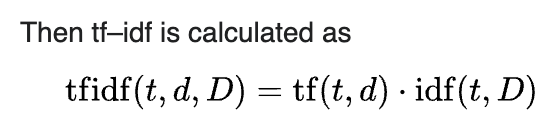


In [ ]:
def create_inverted_index_with_tf_idf_weights(data,new_index_name, bucket_name, folder):
    #---------------- Initialize Index ---------------
    body_index = InvertedIndex()

    #------------------- Posting ---------------------
    word_counts = data.flatMap(lambda x: word_count(x[1], x[0]))
    postings = word_counts.groupByKey().mapValues(reduce_word_counts)
    postings = postings.filter(lambda x: len(x[1])>50) 

    #----------------------- DF -----------------------
    tf = postings.flatMap(lambda x: [(tup[0], (x[0],tup[1])) for tup in x[1]] ) 
    tf = tf.groupByKey().mapValues(list)

    #-------------------calculate df-------------------
    doc_lens = tf.map(lambda x: (x[0],builtins.sum([tup[1] for tup in x[1]])))
    doc_lens = doc_lens.collectAsMap()
    
    w2df = calculate_df(postings)
    w2df_dict = w2df.collectAsMap()
    
    #------------------- Posting Locs -------------------
    _ = partition_postings_and_write(postings, bucket_name, folder).collect()
    super_posting_locs = defaultdict(list)
    #-------gcp---------
    for blob in client.list_blobs(bucket_name, prefix='body100'):
      if not blob.name.endswith("pickle"):
        continue
      with blob.open("rb") as f:
        posting_locs = pickle.load(f)
        for k, v in posting_locs.items():
          super_posting_locs[k].extend(v)

    body_index.posting_locs = super_posting_locs
    body_index.df = w2df_dict
    body_index.N= data.count() #need update inverted index
    
    #---------------------- Write ---------------------
    tf_idf = tf.flatMap(lambda x: [(x[0],(tup[0], calc_tf_idf(tup[1], body_index.N , body_index.df[tup[0]], doc_lens[x[0]]))) for tup in x[1]] ) 
    tf_idf = tf_idf.groupByKey().mapValues(dict)
    #truning tf_idf rdd to docid: (doc_len,sum-mechane of cosSim)
    tf_idf = tf_idf.map(lambda x: (x[0],(doc_lens[x[0]],builtins.sum(math.pow(y,2) for y in x[1].values() ))))   
    body_index.weights = tf_idf.collectAsMap() #need update inverted index
    # write the global stats out
    body_index.write_index('.', new_index_name)

    return body_index

In [ ]:
folder = "body100"
body100_index = create_inverted_index_with_tf_idf_weights(body_data,"body100_index", bucket_name, folder)
print("done creating body _index")

In [ ]:
# upload to gs
index_src = "body100_index.pkl"
index_dst = f'gs://{bucket_name}/body100/{index_src}'
!gsutil cp $index_src $index_dst
!gsutil ls -lh $index_dst

# **Inverted Index Anchor:**


---
In Anchor text we use difference text operation, we don't use Stemming  




In [ ]:
doc_text_pairs = parquetFile.select("anchor_text", "id").rdd
anchor_text_joined = doc_text_pairs.flatMap(lambda x: x.anchor_text).reduceByKey(lambda x,y: x+" "+y)

def tokenize_anchor(text):      
  english_stopwords = frozenset(stopwords.words('english'))
  corpus_stopwords = ["category", "references", "also", "external", "links", 
                      "may", "first", "see", "history", "people", "one", "two", 
                      "part", "thumb", "including", "second", "following", 
                      "many", "however", "would", "became", "make", "good", "worst"]

  all_stopwords = english_stopwords.union(corpus_stopwords)
  RE_WORD = re.compile(r"""[\#\@\w](['\-]?\w){2,24}""", re.UNICODE)
  tokens = [token.group() for token in RE_WORD.finditer(text.lower()) if token.group() not in all_stopwords]
  return tokens

In [ ]:
def word_count_anchor(text, id):
  ''' Count the frequency of each word in `text` (tf) that is not included in 
  `all_stopwords` and return entries that will go into our posting lists. 
  Parameters:
  -----------
    text: str
      Text of one document
    id: int
      Document id
  Returns:
  --------
    List of tuples
      A list of (token, (doc_id, tf)) pairs 
      for example: [("Anarchism", (12, 5)), ...]
  '''
  #change tokenize
  tokens = tokenize_anchor(text)
  # YOUR CODE HERE
  counter = Counter(tokens) # Using Counter().
  lst_of_tuples = []
  for token in counter:
    lst_of_tuples.append((token, (id, counter[token])))
  return lst_of_tuples

In [ ]:
#---------------- Initialize Index ---------------
inverted = InvertedIndex()
#------------------- Posting ---------------------
folder = "anchor4"
word_counts = anchor_text_joined.flatMap(lambda x: word_count(x[1], x[0]))
postings = word_count_anchor.groupByKey().mapValues(reduce_word_counts)
#----------------------- DF -----------------------
w2df = calculate_df(postings)
w2df_dict = w2df.collectAsMap()

#------------------- Posting Locs -------------------

_ = partition_postings_and_write(postings, bucket_name, folder).collect()
super_posting_locs = defaultdict(list)
#-------gcp---------
for blob in client.list_blobs(bucket_name, prefix=folder):
  if not blob.name.endswith("pickle"):
    continue
  with blob.open("rb") as f:
    posting_locs = pickle.load(f)
    for k, v in posting_locs.items():
      super_posting_locs[k].extend(v) 

In [ ]:
#---------------------- Write ---------------------
inverted.posting_locs = super_posting_locs
inverted.df = w2df_dict
inverted.write_index('.', 'anchor4_index')

In [ ]:
# upload to gs
index_src = "anchor4_index.pkl"
index_dst = f'gs://{bucket_name}/anchor4/{index_src}'
!gsutil cp $index_src $index_dst
!gsutil ls -lh $index_dst

# **Inverted Index BM25**:


---



In this section we will create an index for the Wikipedia title and body, we will use the BN25 method.

**BM25**  is a bag-of-words retrieval function that ranks a set of documents based on the query terms appearing in each document, regardless of their proximity within the document. 

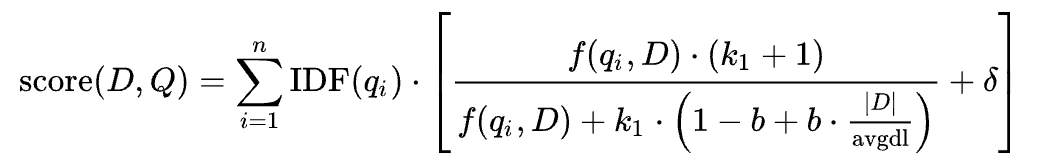

## Create body index BM25


---



In [ ]:
def create_body_index_bm_25(data,new_index_name, bucket_name, folder):
    #---------------- Initialize Index ---------------
    index_body_bm25 = InvertedIndex()

    #------------------- Posting ---------------------
    word_counts = data.flatMap(lambda x: word_count(x[1], x[0]))
    postings = word_counts.groupByKey().mapValues(reduce_word_counts)
    postings = postings.filter(lambda x: len(x[1])>50) 

    #----------------------- DF -----------------------
    tf = postings.flatMap(lambda x: [(tup[0], (x[0],tup[1])) for tup in x[1]] ) 
    tf = tf.groupByKey().mapValues(list)

    #--------------- calculation bm25 -------------
    doc_lens_rdd = tf.map(lambda x: (x[0],builtins.sum([tup[1] for tup in x[1]])))
    doc_lens = doc_lens_rdd.collectAsMap()
    w2df = calculate_df(postings)
    w2df_dict = w2df.collectAsMap()
    avgdl = builtins.sum(doc_lens.values())/len(doc_lens)

    #------------------- Posting Locs -------------------
    _ = partition_postings_and_write(postings, bucket_name, folder).collect()
    super_posting_locs = defaultdict(list)
    #-------gcp---------
    for blob in client.list_blobs(bucket_name, prefix='body_bm25'):
      if not blob.name.endswith("pickle"):
        continue
      with blob.open("rb") as f:
        posting_locs = pickle.load(f)
        for k, v in posting_locs.items():
          super_posting_locs[k].extend(v)

    #---------------------- Write ---------------------
    index_body_bm25.posting_locs = super_posting_locs
    index_body_bm25.df = w2df_dict
    index_body_bm25.N= data.count()
    bm25 = doc_lens_rdd.map(lambda x: (x[0],calc_bm25(x[1], avgdl,1.5,0.75)))
    index_body_bm25.weights = bm25.collectAsMap()
    index_body_bm25.write_index('.', new_index_name)
    return index_body_bm25

In [ ]:
folder = "body_bm25"
body_bm25 = create_body_index_bm_25(body_data,"body_bm25", bucket_name, folder)
print("done creating body")

In [ ]:
# upload to gs
index_src = "body_bm25.pkl"
index_dst = f'gs://{bucket_name}/body_bm25/{index_src}'
!gsutil cp $index_src $index_dst
!gsutil ls -lh $index_dst

## Create title index BM25


---


In [ ]:
def create_title_index_with_bm_25_weights(data,new_index_name, bucket_name, folder):
    #---------------- Initialize Index ---------------
    index_title_bm25 = InvertedIndex()

    #------------------- Posting ---------------------
    word_counts = data.flatMap(lambda x: word_count(x[1], x[0]))
    postings = word_counts.groupByKey().mapValues(reduce_word_counts)

    #----------------------- DF -----------------------
    tf = postings.flatMap(lambda x: [(tup[0], (x[0],tup[1])) for tup in x[1]] ) 
    tf = tf.groupByKey().mapValues(list)

    #--------------- calculation bm25 -------------
    doc_lens_rdd = tf.map(lambda x: (x[0],builtins.sum([tup[1] for tup in x[1]])))
    doc_lens = doc_lens_rdd.collectAsMap()
    w2df = calculate_df(postings)
    w2df_dict = w2df.collectAsMap()
    avgdl = builtins.sum(doc_lens.values())/len(doc_lens)

    #------------------- Posting Locs -------------------
    _ = partition_postings_and_write(postings,new_index_name).collect()
    super_posting_locs = defaultdict(list)
    #-------gcp---------
    for blob in client.list_blobs(bucket_name, prefix=folder):
      if not blob.name.endswith("pickle"):
        continue
      with blob.open("rb") as f:
        posting_locs = pickle.load(f)
        for k, v in posting_locs.items():
          super_posting_locs[k].extend(v)

    #---------------------- Write ---------------------
    index_title_bm25.posting_locs = super_posting_locs
    index_title_bm25.df = w2df_dict
    index_title_bm25.N= data.count()
    bm25 = doc_lens_rdd.map(lambda x: (x[0],calc_bm25(x[1], avgdl,1.5,0.75)))
    index_title_bm25.weights = bm25.collectAsMap()
    index_title_bm25.write_index('.', new_index_name)

    return index_title_bm25

In [ ]:
folder = "title_bm25"
title_bm25 = create_title_index_with_bm_25_weights(title_data,"index_title_bm25", bucket_name, folder)
print("done creating title")

In [ ]:
# upload to gs
index_src = "index_title_bm25.pkl"
index_dst = f'gs://{bucket_name}/title_bm25/{index_src}'
!gsutil cp $index_src $index_dst
!gsutil ls -lh $index_dst